# PROCESSAMENTO DIGITAL DE SINAIS

# Sumário

1. [Complexidade Computacional](#complexidadecomputacional)

2. [Convolução](#convolution)



<a id="complexidadecomputacional"></a>
# Complexidade Computacional

A complexidade computacional mede o quão custoso é um algoritmo, tanto em questão de uso de recursos, como capacidade de processamento e memória, como em termos de tempo de execução. No contexto de processamento digital de sinais, essa métrica é importante, pois em geral, algoritmos de PDS lidam com sinais em tempo real, em hardware com recursos limitados, e portanto presisam operar rapidamente, de forma a não comprometer a comunicação, não esgotar os recursos disponíveis, e manter a qualidade do sinal e a menor latência possível.

Para isso, é necessário estabelecer a métrica dessa complexidade, e buscar formas, como avaliar diferentes algoritmos para determinado processamento de modo a reduzir o uso de recursos e otimizar o código. Em geral, obtém-se o nível de complexidade do aloritmoa  partir da quantidade de operações realizadas, que depende diretamente do tamanho do objeto que passa pelo processamento. Observar e analisar como o número de operações cresce conforme se aumenta o tamanho e a dimensão do objeto é o que determina o quão complexo é tal algoritmo.

Esse fator serão estudados esse fator de complexidade e técnicas de aceleração de código ao longo dessa capcitação.

<a id="convolution"></a>
# Convolução

A soma de convolução é uma operação de suma importância no contexto de processamento digital de sinais. A partir dessa operação , é possível determinar a saída de um sistema linear qualquer, bastando conhecer a resposta que esse sistema retorna  quando aplicamos um impulso à sua entrada. Dessa forma, podemos escrever a saída do sistema linear disscreto $y(n)$ como:

$$y(n) = \sum _{l = -\infty}^infty x(k) h(n-k)$$

Ou seja, a saída do sistema é equivalente ao resultado da convolução da entrada $x(n)$ com a aresposta ao impulso do sistema $h(n)$

O exemplo abaixo define um sistema $H(x)$ que desloca o sinal de entrada $x$ em 100 amostras. Em seguida, obtém-se o sinal resposta ao impulso desse sistema $h_n$ ao aplicar um impulso como entrada ao sistema. Em seguida, a função *Conv_sum* realiza a soma de convolução entre um pulso retangular e a resposta ao impulso do sistema H. Note que o pulso é deslocado no tempo para a posição do impulso atrasado. Essa é a saída do sistema caso seja aplicado um pulso retangular à sua entrada.

A soma de convolução de sinais discretos retona um sinal que possui uma duração em $t$ de $M-1+N-1$ amostras. Assim, para que o sinal de saída tenha o mesmo tamanho do sinal de entrada, é necessário eliminar valores das extremidades do sinal de saída e obter apenas os vaores centrais. Essa escolha é permitida na função, a partir da escolha do parâmetro *mode*. 

A complexidade da convolução como é feita no exemplo é obtida a partir do cálculo da quantidade de operações. A função é feita a partir de dois laços, onde o laço externo roda M+N-1 vezes e o laço interno roda N vezes, de modo que a quantidade de operações obedece uma relação que varia com $N^2$.

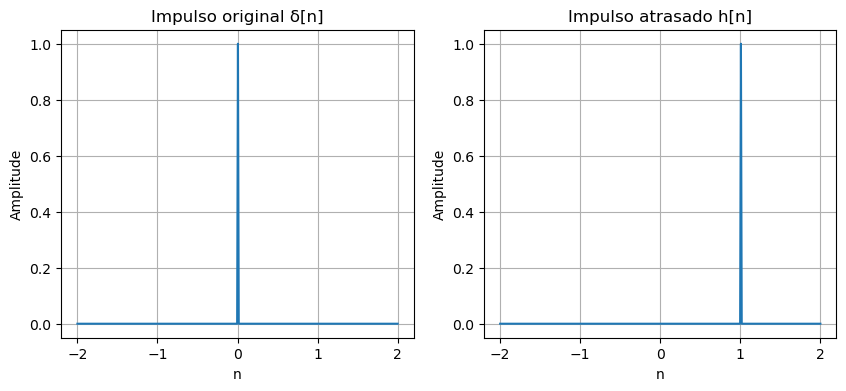

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

f_s = 100  # Frequência de amostragem em Hz
N = 4*f_s  # Número de amostras
T = 1.5  # Tempo de deslocamento em segundos
n = np.linspace(-2, 2, N)
x_n = np.where(np.abs(n) < 0.5, 1, 0)

idx0= np.argmin(np.abs(n-0.0)) # Índice do impulso unitário

# Impulso unitário
delta = np.zeros_like(n)    
delta[idx0] = 1

def H(x, T, f_s):
    """
    Função que desloca o sinal de entrada em 100 amostras.

    Args:
        x (np.ndarray): Sinal de entrada.
        T (float): Deslocamento do sinal em segundos.
        f_s (int): Frequência de amostragem do sinal.
    Returns:
        np.ndarray: Sinal deslocado.
    """
    d = int(f_s * T)  # Deslocamento em amostras
    N = len(x)
    y = np.zeros_like(x)
    if(f_s * T >= N):
        raise ValueError("O deslocamento T é muito grande para o tamanho do sinal.")
    y[d:N] = x[:N-d]
    return y

h_n = H(delta, 1, f_s)

fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Impulso original
axs[0].plot(n, delta)
axs[0].set_title('Impulso original δ[n]')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Impulso atrasado
axs[1].plot(n, h_n)
axs[1].set_title('Impulso atrasado h[n]')
axs[1].set_xlabel('n')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)


plt.show()

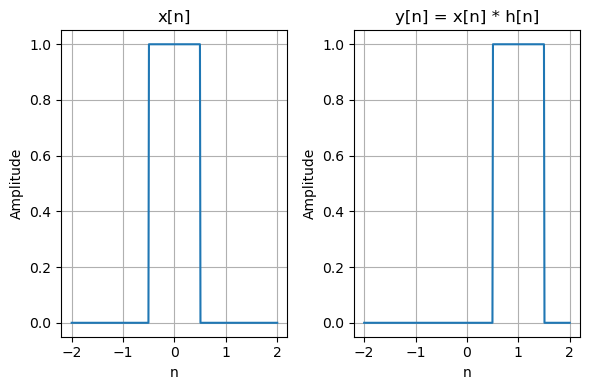

In [27]:
def Conv_sum(x, h, mode='full'):
    """
    Função que calcula a convolução de dois sinais x e h.

    A convolução retorna um sinal de tamanho (M+N-1). Isso se deve ao fato da convolução deslocar o sinal de N amostras em M amostras, ou seja, o índice do sinal resultante começa em 0, e segue até (N-1)+(M-1),
    totalizando N+M-1 índices, ou amostras.

    Caso o modo seja 'full', a função retorna o resultado completo da convolução.
    Caso o modo seja 'same', a função retorna apenas a parte dentral do resultado com o mesmo tamanho do sinal de entrada x.

    args:
        x (np.ndarray): Sinal de entrada.
        h (np.ndarray): Resposta ao Impulso.
        mode (str): Modo da convolução, pode ser 'full' ou 'same'.
    returns:
        np.ndarray: Sinal resultante da convolução.
    """
    N = len(x)
    M = len(h)
    y = np.zeros(N + M - 1)

    for n in range(N + M - 1):
            for k in range(N):
                  y[n] += x[k] * h[n-k] if 0 <= n - k < M else 0
    
    if mode == 'full':
        return y                                #y = np.convolve(x_n, h_n, mode='full')
    elif mode == 'same':
        begin = ceil((M-1)/2)
        return y[begin:begin + N]         #y = np.convolve(x_n, h_n, mode='same')

y_n = Conv_sum(x_n, h_n)
y_same = Conv_sum(x_n, h_n, mode='same')

t = np.linspace(-2, 2, len(y_same))

# plotando os resultados
fig, axs = plt.subplots(1,2,figsize=(6, 4))
axs[0].plot(n, x_n)
axs[0].set_title('x[n]')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

axs[1].plot(t, y_same)
axs[1].set_title('y[n] = x[n] * h[n]')
axs[1].set_xlabel('n')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

plt.tight_layout()
plt.show()



